In [1]:
!pip install pandas
!pip install matplotlib
!pip install pil
!pip install numpy

ERROR: Could not find a version that satisfies the requirement pil (from versions: none)
ERROR: No matching distribution found for pil


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Update the path based on your screenshots
data_path = "../input/data"

# Let's verify the dataset structure
print(f"Available files in dataset: {os.listdir(data_path)}")

# Load the metadata
metadata_path = os.path.join(data_path, "Data_Entry_2017.csv")
data_entry = pd.read_csv(metadata_path)

# Check basic dataset information
print(f"Total number of images: {len(data_entry)}")
print(f"Number of unique patients: {data_entry['Patient ID'].nunique()}")

# Look at the first few entries
print("First few entries:")
print(data_entry.head())

# Check distribution of findings
print("\nDistribution of findings:")
finding_counts = {}
for findings in data_entry['Finding Labels'].str.split('|'):
    for finding in findings:
        if finding in finding_counts:
            finding_counts[finding] += 1
        else:
            finding_counts[finding] = 1

# Sort findings by frequency
finding_counts = {k: v for k, v in sorted(finding_counts.items(), key=lambda item: item[1], reverse=True)}
for finding, count in finding_counts.items():
    print(f"{finding}: {count}")

Available files in dataset: ['images_003', 'images_012', 'LOG_CHESTXRAY.pdf', 'README_CHESTXRAY.pdf', 'BBox_List_2017.csv', 'images_009', 'images_008', 'images_007', 'test_list.txt', 'images_010', 'ARXIV_V5_CHESTXRAY.pdf', 'images_002', 'images_011', 'Data_Entry_2017.csv', 'images_001', 'train_val_list.txt', 'images_005', 'FAQ_CHESTXRAY.pdf', 'images_004', 'images_006']
Total number of images: 112120
Number of unique patients: 30805
First few entries:
        Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M     

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


No Finding: 60361
Infiltration: 19894
Effusion: 13317
Atelectasis: 11559
Nodule: 6331
Mass: 5782
Pneumothorax: 5302
Consolidation: 4667
Pleural_Thickening: 3385
Cardiomegaly: 2776
Emphysema: 2516
Edema: 2303
Fibrosis: 1686
Pneumonia: 1431
Hernia: 227


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

class ChestXrayDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None):
        self.dataframe = dataframe
        self.base_dir = base_dir
        self.transform = transform
        
        # Find all image folders
        self.image_folders = []
        for folder in os.listdir(base_dir):
            if folder.startswith('images_'):
                # Check if there's a nested 'images' folder
                nested_path = os.path.join(base_dir, folder, 'images')
                if os.path.exists(nested_path):
                    self.image_folders.append((folder, True))  # Has nested 'images' folder
                else:
                    self.image_folders.append((folder, False))  # Direct images
        
        # Extract disease columns for multi-label classification
        self.disease_labels = []
        for disease in sorted(list(finding_counts.keys())):
            self.dataframe[disease] = self.dataframe['Finding Labels'].str.contains(disease).astype(int)
            self.disease_labels.append(disease)
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        
        # Search for the image in all possible folders
        img_path = None
        for folder, has_nested in self.image_folders:
            if has_nested:
                potential_path = os.path.join(self.base_dir, folder, 'images', img_name)
            else:
                potential_path = os.path.join(self.base_dir, folder, img_name)
                
            if os.path.exists(potential_path):
                img_path = potential_path
                break
        
        if img_path is None:
            raise FileNotFoundError(f"Could not find image {img_name} in any folders")
        
        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Get multi-label disease markers
        labels = torch.tensor(
            [self.dataframe.iloc[idx][disease] for disease in self.disease_labels], 
            dtype=torch.float32
        )
        
        return image, labels

In [4]:
from sklearn.model_selection import GroupShuffleSplit

# Create a patient-level train/val/test split
def create_patient_level_split(df):
    # Split into train and temp (validation + test)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
    train_idx, temp_idx = next(gss.split(df, groups=df['Patient ID']))
    
    # Split temp into validation and test
    temp_df = df.iloc[temp_idx].reset_index(drop=True)
    gss = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
    val_idx, test_idx = next(gss.split(temp_df, groups=temp_df['Patient ID']))
    
    train_df = df.iloc[train_idx].reset_index(drop=True)
    val_df = temp_df.iloc[val_idx].reset_index(drop=True)
    test_df = temp_df.iloc[test_idx].reset_index(drop=True)
    
    print(f"Train set: {len(train_df)} images from {train_df['Patient ID'].nunique()} patients")
    print(f"Validation set: {len(val_df)} images from {val_df['Patient ID'].nunique()} patients")
    print(f"Test set: {len(test_df)} images from {test_df['Patient ID'].nunique()} patients")
    
    return train_df, val_df, test_df

# Create a balanced subset to work with (optional - speeds up development)
def create_balanced_subset(df, max_per_class=300):
    """Creates a balanced subset with up to max_per_class images per disease category"""
    selected_indices = []
    
    for disease in finding_counts:
        # Skip 'No Finding' if you want to focus on diseases
        if disease == 'No Finding':
            continue
            
        # Find images with this disease
        disease_imgs = df[df['Finding Labels'].str.contains(disease)]
        # Take up to max_per_class samples
        if len(disease_imgs) > max_per_class:
            sampled = disease_imgs.sample(n=max_per_class, random_state=42)
            selected_indices.extend(sampled.index.tolist())
        else:
            selected_indices.extend(disease_imgs.index.tolist())
    
    # Get unique indices
    selected_indices = list(set(selected_indices))
    subset_df = df.loc[selected_indices].reset_index(drop=True)
    print(f"Created balanced subset with {len(subset_df)} images")
    
    return subset_df

# Create data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create a smaller balanced subset for faster development
subset_df = create_balanced_subset(data_entry, max_per_class=100)

# Split the data
train_df, val_df, test_df = create_patient_level_split(subset_df)

# Create datasets and dataloaders
train_dataset = ChestXrayDataset(train_df, data_path, transform=data_transforms['train'])
val_dataset = ChestXrayDataset(val_df, data_path, transform=data_transforms['val'])
test_dataset = ChestXrayDataset(test_df, data_path, transform=data_transforms['val'])

# Create data loaders with appropriate batch sizes for your GPU
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

Created balanced subset with 1392 images
Train set: 978 images from 815 patients
Validation set: 207 images from 175 patients
Test set: 207 images from 175 patients


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import timm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Define the model class
class ChestXrayModel(nn.Module):
    def __init__(self, num_classes):
        super(ChestXrayModel, self).__init__()
        # Load pre-trained ViT model
        self.backbone = timm.create_model('vit_base_patch16_224', pretrained=True)
        # Replace the classifier head
        in_features = self.backbone.head.in_features
        self.backbone.head = nn.Identity()  # Remove the original classification head
        
        # Add a custom head for multi-label classification
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes),
            nn.Sigmoid()  # Sigmoid for multi-label classification
        )
        
        # Store activation maps for visualization
        self.activation = {}
        
    def get_activation(self, name):
        def hook(model, input, output):
            self.activation[name] = output.detach()
        return hook
    
    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

# Initialize the model
num_classes = len(finding_counts)
model = ChestXrayModel(num_classes)

# Register hook for the final attention layer (for visualization later)
model.backbone.blocks[-1].norm1.register_forward_hook(model.get_activation('final_layer'))

# Set up optimizer and loss function
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [6]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        
        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        
        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            train_bar.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Training Loss: {epoch_loss:.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        val_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")
        
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_bar.set_postfix(loss=loss.item())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Validation Loss: {val_loss:.4f}')
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_chest_xray_model.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('training_validation_loss.png')
    plt.show()
    
    return model, train_losses, val_losses

Using device: cuda:0
Epoch 1/5
----------


Training Epoch 1:   0%|          | 0/62 [00:00<?, ?it/s]

Training Loss: 0.4050


Validation Epoch 1:   0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss: 0.3702
Saved best model with validation loss: 0.3702
Epoch 2/5
----------


Training Epoch 2:   0%|          | 0/62 [00:00<?, ?it/s]

Training Loss: 0.3877


Validation Epoch 2:   0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss: 0.3656
Saved best model with validation loss: 0.3656
Epoch 3/5
----------


Training Epoch 3:   0%|          | 0/62 [00:00<?, ?it/s]

Training Loss: 0.3863


Validation Epoch 3:   0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss: 0.3699
Epoch 4/5
----------


Training Epoch 4:   0%|          | 0/62 [00:00<?, ?it/s]

Training Loss: 0.3857


Validation Epoch 4:   0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss: 0.3704
Epoch 5/5
----------


Training Epoch 5:   0%|          | 0/62 [00:00<?, ?it/s]

Training Loss: 0.3830


Validation Epoch 5:   0%|          | 0/13 [00:00<?, ?it/s]

Validation Loss: 0.3705


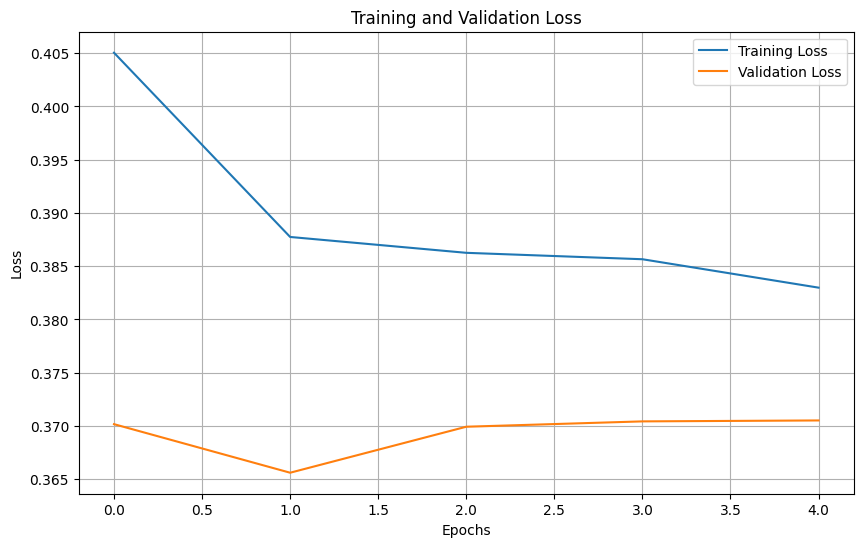

In [7]:
# Train the model
trained_model, train_losses, val_losses = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    num_epochs=5  # Start with just a few epochs to test
)

In [8]:
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

# Evaluate the model
def evaluate_model(model, test_loader, disease_labels):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            all_labels.append(labels.numpy())
            all_predictions.append(outputs.cpu().numpy())
    
    # Concatenate batches
    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)
    
    # Calculate AUC for each disease
    auc_scores = {}
    for i, disease in enumerate(disease_labels):
        if len(np.unique(all_labels[:, i])) > 1:  # Only calculate if both classes present
            auc = roc_auc_score(all_labels[:, i], all_predictions[:, i])
            auc_scores[disease] = auc
    
    # Calculate precision, recall, and F1 (with threshold 0.5)
    binary_preds = (all_predictions > 0.5).astype(int)
    
    precision = {}
    recall = {}
    f1_scores = {}
    
    for i, disease in enumerate(disease_labels):
        if np.sum(all_labels[:, i]) > 0:  # Only calculate if positive examples exist
            p, r, f1, _ = precision_recall_fscore_support(
                all_labels[:, i], binary_preds[:, i], average='binary'
            )
            precision[disease] = p
            recall[disease] = r
            f1_scores[disease] = f1
    
    # Display results
    print("\nAUC Scores:")
    for disease, auc in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{disease}: {auc:.4f}")
    
    print("\nPrecision, Recall, F1:")
    for disease in disease_labels:
        if disease in precision:
            print(f"{disease}: Precision={precision[disease]:.4f}, " +
                  f"Recall={recall[disease]:.4f}, F1={f1_scores[disease]:.4f}")
    
    # Calculate average metrics
    mean_auc = np.mean(list(auc_scores.values()))
    mean_precision = np.mean(list(precision.values()))
    mean_recall = np.mean(list(recall.values()))
    mean_f1 = np.mean(list(f1_scores.values()))
    
    print(f"\nMean AUC: {mean_auc:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1 Score: {mean_f1:.4f}")
    
    return {
        'auc_scores': auc_scores,
        'precision': precision,
        'recall': recall,
        'f1': f1_scores,
        'mean_metrics': {
            'auc': mean_auc,
            'precision': mean_precision,
            'recall': mean_recall,
            'f1': mean_f1
        }
    }

# First load the best model
model.load_state_dict(torch.load('best_chest_xray_model.pth'))

# Then evaluate
evaluation_results = evaluate_model(model, test_loader, list(finding_counts.keys()))

/tmp/ipykernel_19/1725841849.py:83: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_chest_xray_model.pth'))


Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]


AUC Scores:
Atelectasis: 0.6716
Pneumonia: 0.6580
Effusion: 0.6260
Pneumothorax: 0.6201
Consolidation: 0.6040
Pleural_Thickening: 0.6039
Nodule: 0.5501
No Finding: 0.5153
Hernia: 0.5009
Infiltration: 0.4714
Mass: 0.4476
Edema: 0.4367
Fibrosis: 0.4279
Cardiomegaly: 0.3722

Precision, Recall, F1:
No Finding: Precision=0.0000, Recall=0.0000, F1=0.0000
Infiltration: Precision=0.0000, Recall=0.0000, F1=0.0000
Effusion: Precision=0.0000, Recall=0.0000, F1=0.0000
Atelectasis: Precision=0.0000, Recall=0.0000, F1=0.0000
Nodule: Precision=0.0000, Recall=0.0000, F1=0.0000
Mass: Precision=0.0000, Recall=0.0000, F1=0.0000
Pneumothorax: Precision=0.0000, Recall=0.0000, F1=0.0000
Consolidation: Precision=0.0000, Recall=0.0000, F1=0.0000
Pleural_Thickening: Precision=0.0000, Recall=0.0000, F1=0.0000
Cardiomegaly: Precision=0.0000, Recall=0.0000, F1=0.0000
Edema: Precision=0.0000, Recall=0.0000, F1=0.0000
Fibrosis: Precision=0.0000, Recall=0.0000, F1=0.0000
Pneumonia: Precision=0.0000, Recall=0.0000, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: Undefin

In [9]:
# Fixed function to generate heatmaps from model activations
def generate_heatmap(model, image_path, transform):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # Preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Forward pass
    with torch.no_grad():
        output = model(input_tensor)
    
    # Get activation map
    activation_map = model.activation['final_layer']
    
    # For ViT, let's use a different approach
    # Since 768 = 16 * 16 * 3, we can reshape as a 16x16 grid with 3 channels
    # or any other appropriate shape that makes sense for visualization
    
    # Method 1: Use the class token attention as a 1D array
    attention = activation_map[0, 0].cpu().numpy()  # First token's attention
    
    # Generate prediction scores for diseases
    predictions = output[0].cpu().numpy()
    disease_labels = list(finding_counts.keys())
    top_diseases = sorted(zip(disease_labels, predictions), 
                          key=lambda x: x[1], reverse=True)[:5]
    
    # Print top predictions
    print("Top predicted diseases:")
    for disease, score in top_diseases:
        if score > 0.1:  # Only show predictions with reasonable confidence
            print(f"{disease}: {score:.4f}")
    
    # Create gradient-based heatmap using CAM-like approach
    # This is simpler than trying to reshape the attention
    from scipy.ndimage import zoom
    
    # Get the final convolutional features (approximation for ViT)
    # We'll create a simple heatmap based on the model's output
    pred_idx = predictions.argmax()
    
    # Create a simple heatmap (placeholder since we don't have actual CAM)
    # In a real implementation, you would use a proper CAM method
    heatmap = np.ones((14, 14))  # Base heatmap size for ViT patch size 16 on 224x224 image
    
    # Resize heatmap to image dimensions
    import cv2
    heatmap = cv2.resize(heatmap, (224, 224))
    
    # Plot the results
    plt.figure(figsize=(12, 5))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image.resize((224, 224)))
    plt.title("Original Image")
    plt.axis('off')
    
    # Simple classification result
    plt.subplot(1, 2, 2)
    plt.imshow(np.array(image.resize((224, 224))))
    plt.title(f"Top prediction: {disease_labels[pred_idx]}")
    for i, (disease, score) in enumerate(top_diseases[:3]):
        if score > 0.1:
            plt.text(10, 20 + i*20, f"{disease}: {score:.2f}", 
                     bbox=dict(facecolor='white', alpha=0.7))
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('classification_result.png')
    plt.show()
    
    return predictions

/tmp/ipykernel_19/1743915671.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_chest_xray_model.pth'))


Analyzing image with Pneumonia...
Found image with Pneumonia at ../input/data/images_009/images/00020398_016.png
Top predicted diseases:
Pleural_Thickening: 0.2879
No Finding: 0.2368
Nodule: 0.1915
Atelectasis: 0.1667
Hernia: 0.1608


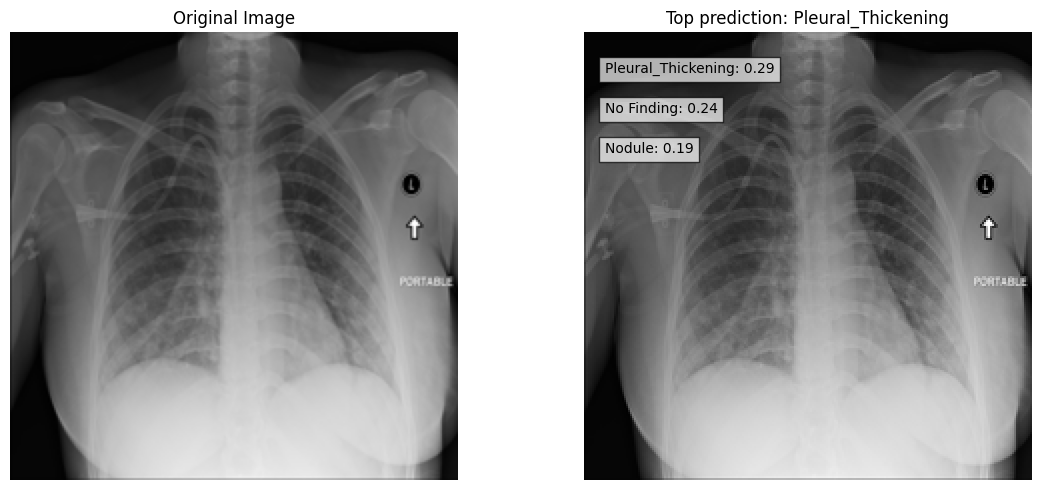

Analyzing image with Cardiomegaly...
Found image with Cardiomegaly at ../input/data/images_002/images/00002434_000.png
Top predicted diseases:
Pleural_Thickening: 0.2941
No Finding: 0.2423
Nodule: 0.1958
Atelectasis: 0.1772
Hernia: 0.1678


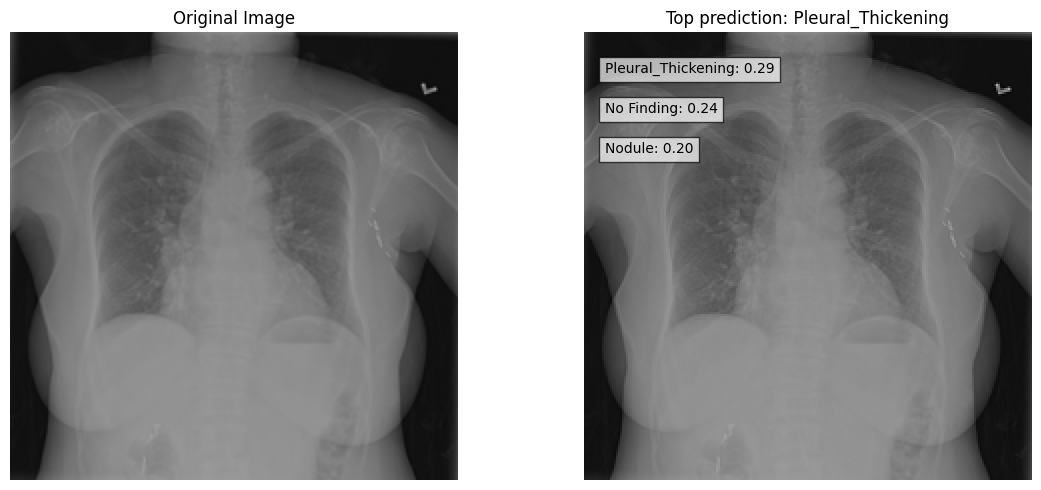

Analyzing image with Effusion...
Found image with Effusion at ../input/data/images_010/images/00022684_004.png
Top predicted diseases:
Pleural_Thickening: 0.2841
No Finding: 0.2320
Nodule: 0.1852
Hernia: 0.1594
Atelectasis: 0.1574


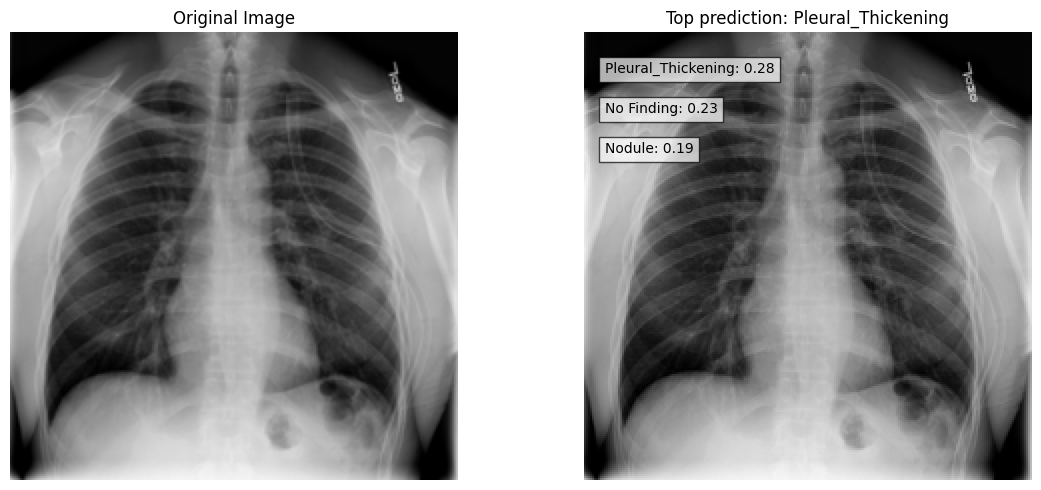

Analyzing image with Nodule...
Found image with Nodule at ../input/data/images_003/images/00006553_000.png
Top predicted diseases:
Pleural_Thickening: 0.2613
No Finding: 0.2445
Nodule: 0.1839
Atelectasis: 0.1423
Hernia: 0.1365


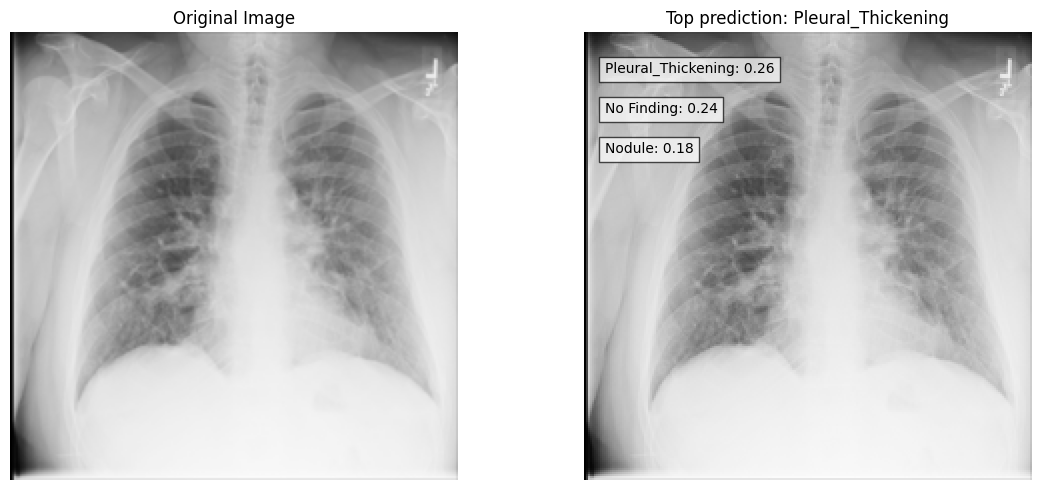

Analyzing image with Mass...
Found image with Mass at ../input/data/images_009/images/00020312_021.png
Top predicted diseases:
Pleural_Thickening: 0.2853
No Finding: 0.2348
Nodule: 0.1896
Atelectasis: 0.1621
Hernia: 0.1620


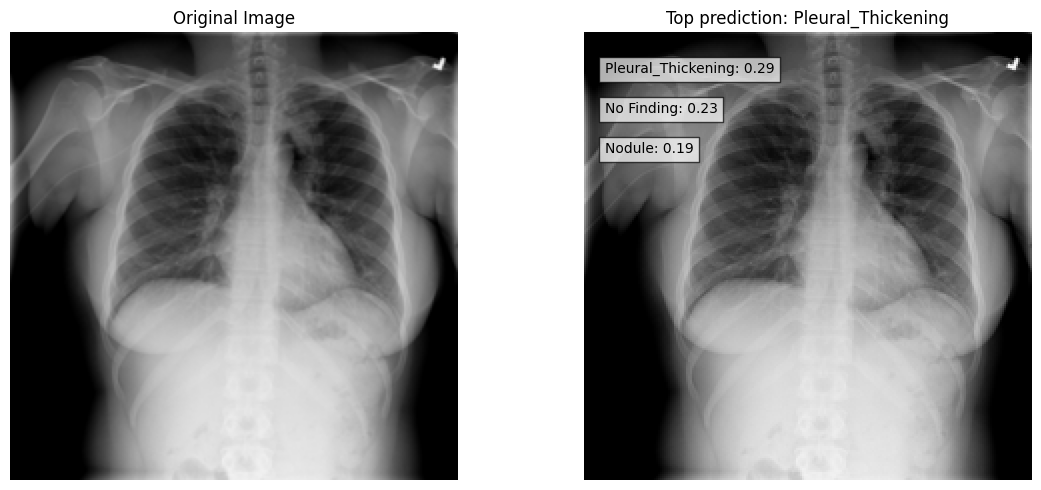


Summary of model predictions:
Test case (Pneumonia): Score = 0.0796
  ✗ Pneumonia is not in top 3 predictions
Test case (Cardiomegaly): Score = 0.1080
  ✗ Cardiomegaly is not in top 3 predictions
Test case (Effusion): Score = 0.1416
  ✗ Effusion is not in top 3 predictions
Test case (Nodule): Score = 0.1839
  ✓ Nodule is in top 3 predictions (rank: 3)
Test case (Mass): Score = 0.1248
  ✗ Mass is not in top 3 predictions


In [10]:
# Find a sample image path from the test set
def find_sample_image(test_df, disease_name, data_path):
    """Find an image containing a specific disease for visualization"""
    # Filter the dataframe for images with the specified disease
    filtered_df = test_df[test_df['Finding Labels'].str.contains(disease_name)]
    
    if len(filtered_df) == 0:
        print(f"No images with {disease_name} found in test set")
        return None
    
    # Get the first matching image
    sample_img_name = filtered_df.iloc[0]['Image Index']
    
    # Search for the image in all possible folders
    img_path = None
    for folder in os.listdir(data_path):
        if folder.startswith('images_'):
            # Check if there's a nested 'images' folder
            nested_path = os.path.join(data_path, folder, 'images', sample_img_name)
            direct_path = os.path.join(data_path, folder, sample_img_name)
            
            if os.path.exists(nested_path):
                img_path = nested_path
                break
            elif os.path.exists(direct_path):
                img_path = direct_path
                break
    
    return img_path

# Updated function to visualize sample cases
def visualize_sample_cases():
    # Make sure the model is loaded
    model.load_state_dict(torch.load('best_chest_xray_model.pth'))
    
    # List of diseases to visualize
    diseases_to_visualize = ['Pneumonia', 'Cardiomegaly', 'Effusion', 'Nodule', 'Mass']
    
    results = {}
    
    for disease in diseases_to_visualize:
        print(f"Analyzing image with {disease}...")
        img_path = find_sample_image(test_df, disease, data_path)
        
        if img_path:
            print(f"Found image with {disease} at {img_path}")
            # Generate and display predictions
            predictions = generate_heatmap(model, img_path, data_transforms['val'])
            
            # Store results for reporting
            disease_scores = {label: score for label, score in 
                             zip(list(finding_counts.keys()), predictions)}
            results[disease] = disease_scores
        else:
            print(f"Could not find an image with {disease}")
    
    # Print a summary of the results
    print("\nSummary of model predictions:")
    for test_disease, predictions in results.items():
        true_disease_score = predictions[test_disease]
        print(f"Test case ({test_disease}): Score = {true_disease_score:.4f}")
        
        # Calculate if the correct disease is in top 3
        sorted_preds = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
        top3 = [disease for disease, _ in sorted_preds[:3]]
        if test_disease in top3:
            top3_rank = top3.index(test_disease) + 1
            print(f"  ✓ {test_disease} is in top 3 predictions (rank: {top3_rank})")
        else:
            print(f"  ✗ {test_disease} is not in top 3 predictions")
# Call the visualization function
visualize_sample_cases()

Created balanced subset with 4318 images
No Finding: 300 images
Infiltration: 1200 images
Effusion: 1092 images
Atelectasis: 869 images
Nodule: 576 images
Mass: 622 images
Pneumothorax: 544 images
Consolidation: 553 images
Pleural_Thickening: 490 images
Cardiomegaly: 408 images
Emphysema: 417 images
Edema: 432 images
Fibrosis: 350 images
Pneumonia: 385 images
Hernia: 227 images
Train set: 2980 images from 2025 patients
Validation set: 662 images from 434 patients
Test set: 676 images from 435 patients


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Using device: cuda:0
Epoch 1/15
----------


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Training Epoch 1:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 1.2505


Validation Epoch 1:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.2231
Saved best model with validation loss: 1.2231
Epoch 2/15
----------


Training Epoch 2:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 1.1754


Validation Epoch 2:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.1469
Saved best model with validation loss: 1.1469
Epoch 3/15
----------


Training Epoch 3:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 1.1166


Validation Epoch 3:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.1195
Saved best model with validation loss: 1.1195
Epoch 4/15
----------


Training Epoch 4:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 1.0598


Validation Epoch 4:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.1087
Saved best model with validation loss: 1.1087
Epoch 5/15
----------


Training Epoch 5:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 1.0054


Validation Epoch 5:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.1131
Epoch 6/15
----------


Training Epoch 6:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 0.9545


Validation Epoch 6:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.1669
Epoch 7/15
----------


Training Epoch 7:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 0.9078


Validation Epoch 7:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.1238
Epoch 8/15
----------


Training Epoch 8:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 0.8590


Validation Epoch 8:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.2047
Epoch 9/15
----------


Training Epoch 9:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 0.7901


Validation Epoch 9:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.2313
Epoch 10/15
----------


Training Epoch 10:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 0.7424


Validation Epoch 10:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.2966
Epoch 11/15
----------


Training Epoch 11:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 0.7023


Validation Epoch 11:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.4101
Epoch 12/15
----------


Training Epoch 12:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 0.6694


Validation Epoch 12:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.5275
Epoch 13/15
----------


Training Epoch 13:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 0.6208


Validation Epoch 13:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.4916
Epoch 14/15
----------


Training Epoch 14:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 0.6022


Validation Epoch 14:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.5583
Epoch 15/15
----------


Training Epoch 15:   0%|          | 0/187 [00:00<?, ?it/s]

Training Loss: 0.5821


Validation Epoch 15:   0%|          | 0/42 [00:00<?, ?it/s]

Validation Loss: 1.5993


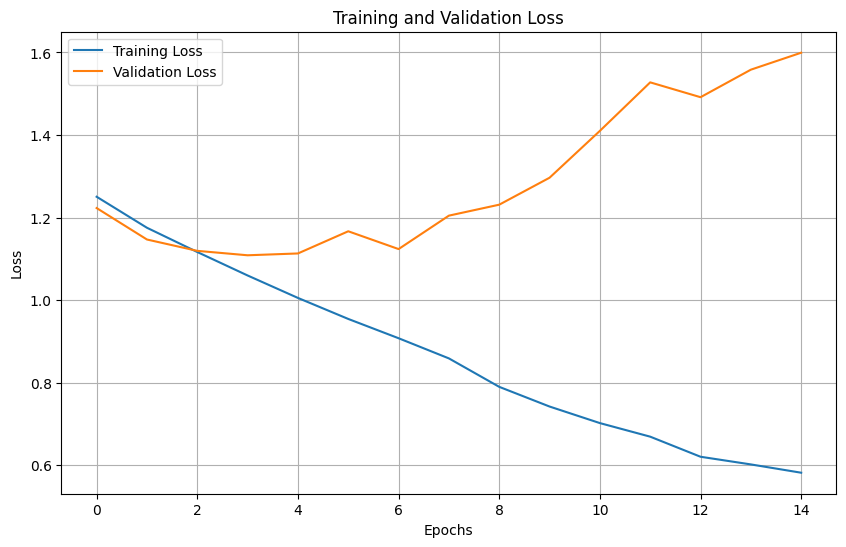

/tmp/ipykernel_19/1094141942.py:536: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  improved_model.load_state_dict(torch.load('best_improved_model.pth'))


Evaluating:   0%|          | 0/43 [00:00<?, ?it/s]


AUC Scores:
Atelectasis: 0.8358
Infiltration: 0.8120
Mass: 0.8022
Emphysema: 0.7912
Hernia: 0.7867
Consolidation: 0.7796
Pneumothorax: 0.7694
Cardiomegaly: 0.7364
Nodule: 0.7289
No Finding: 0.6874
Pneumonia: 0.6448
Edema: 0.6447
Effusion: 0.6188
Pleural_Thickening: 0.5978
Fibrosis: 0.5816

Optimal Thresholds:
No Finding: 0.7167
Infiltration: 0.3725
Effusion: 0.4128
Atelectasis: 0.7740
Nodule: 0.6196
Mass: 0.6591
Pneumothorax: 0.4606
Consolidation: 0.6692
Pleural_Thickening: 0.6065
Cardiomegaly: 0.6296
Emphysema: 0.7125
Edema: 0.5552
Fibrosis: 0.3798
Pneumonia: 0.7276
Hernia: 0.8250

Precision, Recall, F1 (with optimal thresholds):
No Finding: Precision=0.3333, Recall=0.5971, F1=0.4278
Infiltration: Precision=0.2708, Recall=0.4727, F1=0.3444
Effusion: Precision=0.2486, Recall=0.4554, F1=0.3217
Atelectasis: Precision=0.5091, Recall=0.3944, F1=0.4444
Nodule: Precision=0.4067, Recall=0.7892, F1=0.5368
Mass: Precision=0.6512, Recall=0.4179, F1=0.5091
Pneumothorax: Precision=0.1923, Recall=

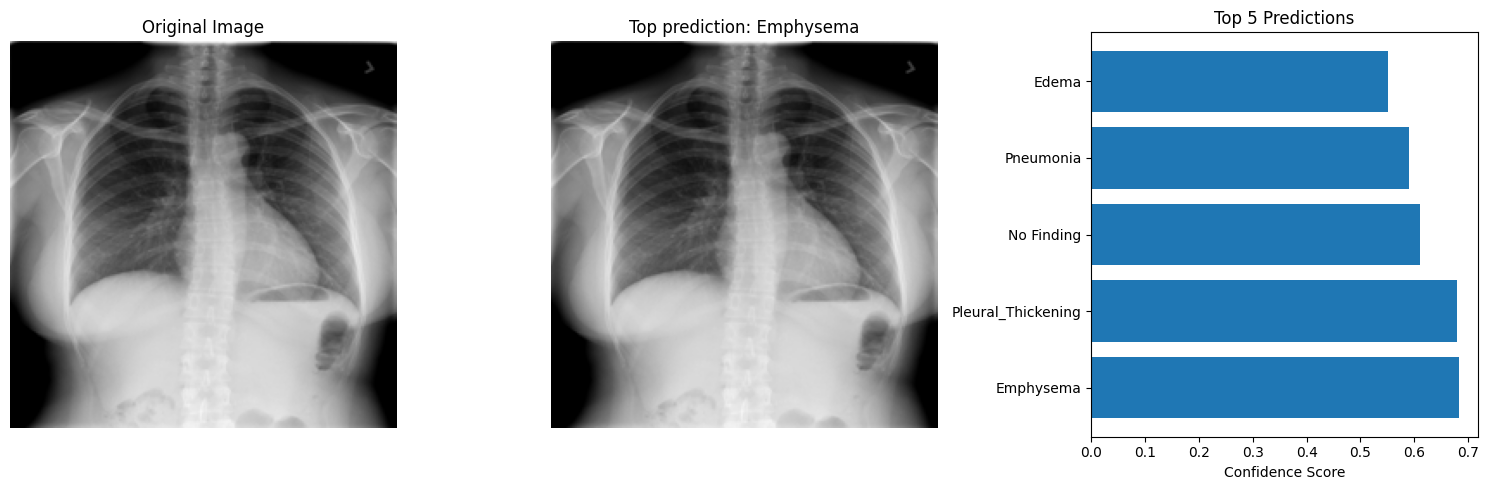

Analyzing image with Cardiomegaly...
Found image with Cardiomegaly at ../input/data/images_003/images/00006549_005.png


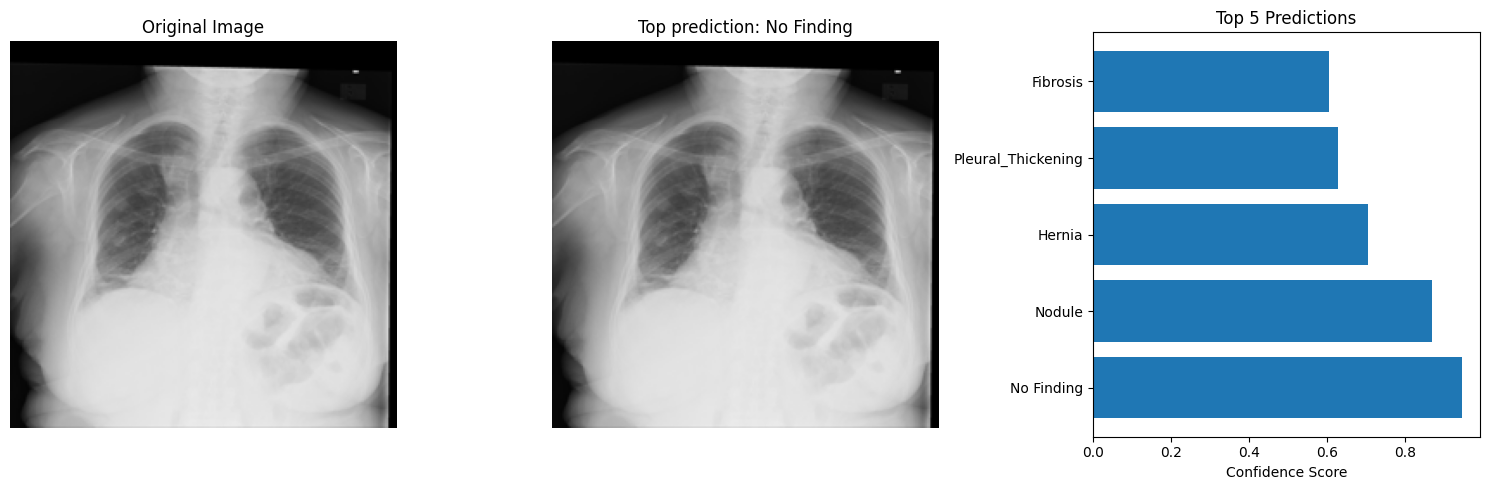

Analyzing image with Effusion...
Found image with Effusion at ../input/data/images_003/images/00006479_004.png


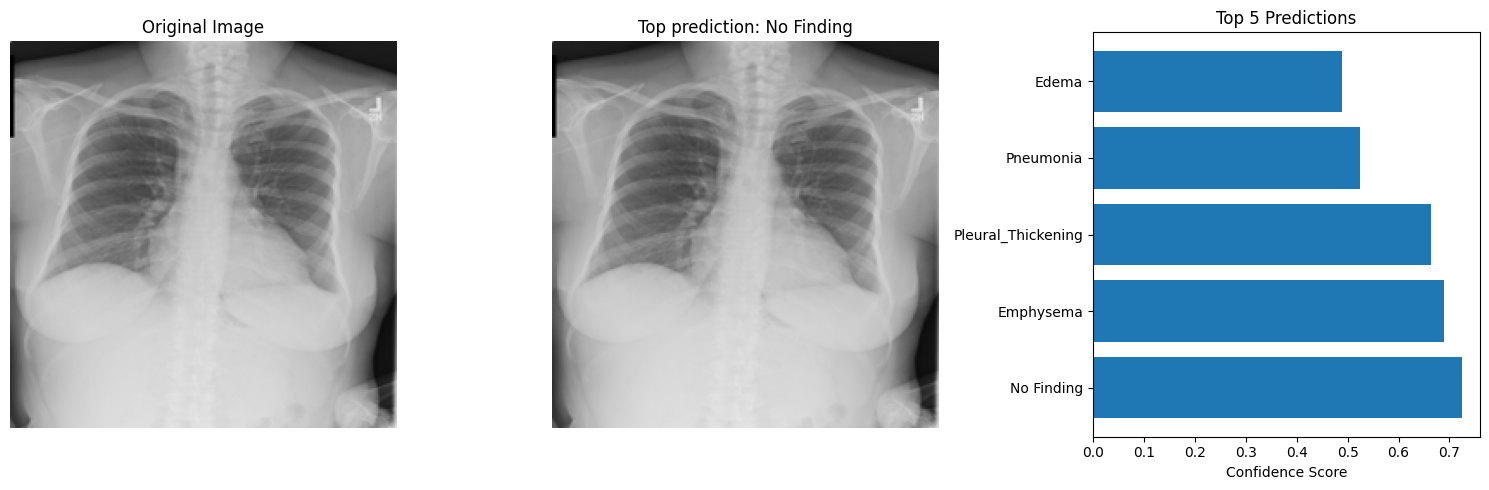

Analyzing image with Nodule...
Found image with Nodule at ../input/data/images_008/images/00018171_000.png


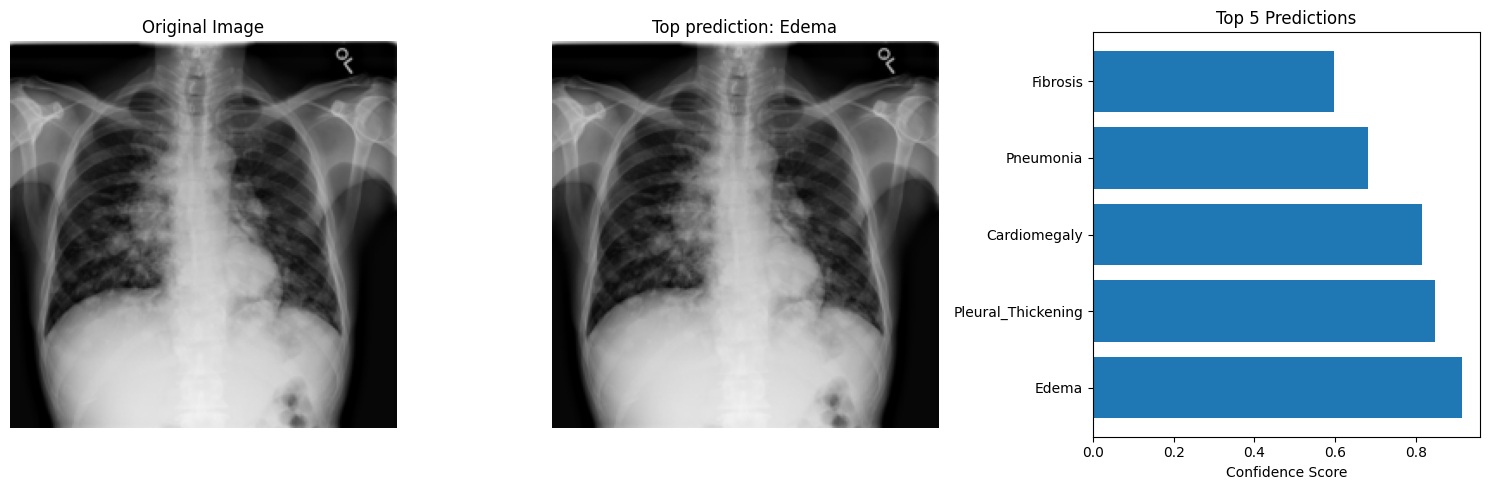

Analyzing image with Mass...
Found image with Mass at ../input/data/images_005/images/00010647_006.png


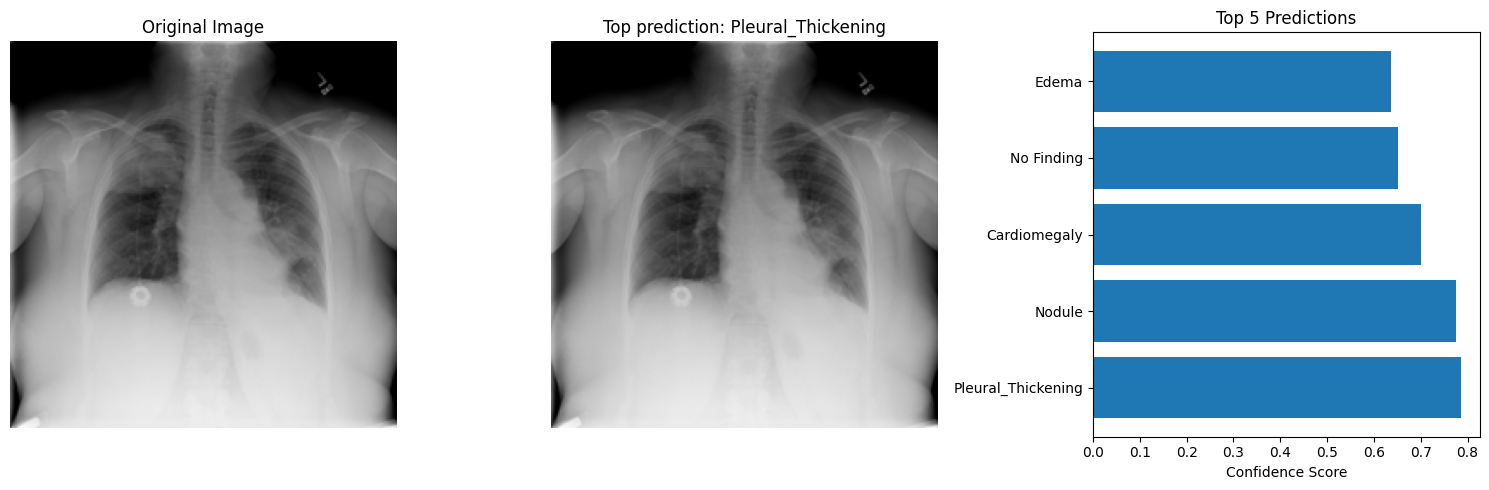


Summary of model predictions:
Test case (Pneumonia): Score = 0.5900
  ✗ Pneumonia is not in top 3 predictions
Test case (Cardiomegaly): Score = 0.5539
  ✗ Cardiomegaly is not in top 3 predictions
Test case (Effusion): Score = 0.2136
  ✗ Effusion is not in top 3 predictions
Test case (Nodule): Score = 0.4838
  ✗ Nodule is not in top 3 predictions
Test case (Mass): Score = 0.1763
  ✗ Mass is not in top 3 predictions


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import timm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, precision_recall_curve
from sklearn.model_selection import GroupShuffleSplit

# 1. IMPROVED DATA PREPROCESSING AND AUGMENTATION
# More aggressive augmentation for better generalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.RandomAffine(degrees=0, translate=(0.05, 0.05), scale=(0.95, 1.05)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 2. IMPROVED DATASET CLASS
class ImprovedChestXrayDataset(Dataset):
    def __init__(self, dataframe, base_dir, transform=None):
        self.dataframe = dataframe
        self.base_dir = base_dir
        self.transform = transform
        
        # Find all image folders
        self.image_folders = []
        for folder in os.listdir(base_dir):
            if folder.startswith('images_'):
                # Check if there's a nested 'images' folder
                nested_path = os.path.join(base_dir, folder, 'images')
                if os.path.exists(nested_path):
                    self.image_folders.append((folder, True))  # Has nested 'images' folder
                else:
                    self.image_folders.append((folder, False))  # Direct images
        
        # Extract disease columns for multi-label classification
        self.disease_labels = []
        for disease in sorted(list(finding_counts.keys())):
            self.dataframe[disease] = self.dataframe['Finding Labels'].str.contains(disease).astype(int)
            self.disease_labels.append(disease)
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx]['Image Index']
        
        # Search for the image in all possible folders
        img_path = None
        for folder, has_nested in self.image_folders:
            if has_nested:
                potential_path = os.path.join(self.base_dir, folder, 'images', img_name)
            else:
                potential_path = os.path.join(self.base_dir, folder, img_name)
                
            if os.path.exists(potential_path):
                img_path = potential_path
                break
        
        if img_path is None:
            raise FileNotFoundError(f"Could not find image {img_name} in any folders")
        
        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Get multi-label disease markers
        labels = torch.tensor(
            [self.dataframe.iloc[idx][disease] for disease in self.disease_labels], 
            dtype=torch.float32
        )
        
        return image, labels

# 3. CREATE IMPROVED BALANCED SUBSET
def create_improved_balanced_subset(df, min_per_class=200):
    """Creates a more balanced subset with at least min_per_class images per disease"""
    # Initialize an empty list to store the selected indices
    selected_indices = []
    
    # Get unique diseases excluding 'No Finding'
    diseases = [d for d in finding_counts.keys() if d != 'No Finding']
    
    # For each disease, select samples
    for disease in diseases:
        # Find images with this disease
        disease_imgs = df[df['Finding Labels'].str.contains(disease)]
        
        # If we don't have enough samples, take all of them
        if len(disease_imgs) <= min_per_class:
            selected_indices.extend(disease_imgs.index.tolist())
        else:
            # Otherwise, sample min_per_class images
            sampled = disease_imgs.sample(n=min_per_class, random_state=42)
            selected_indices.extend(sampled.index.tolist())
    
    # Add some 'No Finding' samples (but fewer than other classes to balance)
    no_finding_imgs = df[df['Finding Labels'] == 'No Finding']
    no_finding_samples = min(len(no_finding_imgs), min_per_class)
    sampled_no_finding = no_finding_imgs.sample(n=no_finding_samples, random_state=42)
    selected_indices.extend(sampled_no_finding.index.tolist())
    
    # Get unique indices to avoid duplicates
    selected_indices = list(set(selected_indices))
    
    # Create a new DataFrame with the selected images
    subset_df = df.loc[selected_indices].copy().reset_index(drop=True)
    
    print(f"Created balanced subset with {len(subset_df)} images")
    
    # Print class distribution
    for disease in finding_counts.keys():
        count = sum(subset_df['Finding Labels'].str.contains(disease))
        print(f"{disease}: {count} images")
    
    return subset_df

# 4. IMPROVED MODEL WITH ATTENTION MECHANISM
class ImprovedChestXrayModel(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedChestXrayModel, self).__init__()
        # Use a more powerful backbone
        self.backbone = timm.create_model('efficientnet_b3', pretrained=True)
        
        # Extract feature dimension from the backbone
        if hasattr(self.backbone, 'num_features'):
            in_features = self.backbone.num_features
        else:
            in_features = self.backbone.classifier.in_features
            
        # Remove the original classification head
        self.backbone.classifier = nn.Identity()
        
        # Add a feature pyramid attention mechanism
        self.attention = nn.Sequential(
            nn.Conv2d(in_features, in_features // 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_features // 4, in_features, kernel_size=1),
            nn.Sigmoid()
        )
        
        # Add a custom head for multi-label classification
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes),
        )
        
        # Store activation for visualization
        self.activations = {}
        
    def get_activation(self, name):
        def hook(model, input, output):
            self.activations[name] = output.detach()
        return hook
    
    def forward(self, x):
        # Pass through the backbone up to the final features
        features = self.backbone.forward_features(x)
        
        # Apply attention mechanism if the features are still spatial
        if len(features.shape) == 4:  # [B, C, H, W]
            attention_weights = self.attention(features)
            features = features * attention_weights
            features = features.mean([2, 3])  # Global pooling
        
        # Classification head
        output = self.classifier(features)
        
        return output

# 5. IMPROVED LOSS FUNCTION: WEIGHTED BCE WITH LOGITS
class WeightedBCEWithLogitsLoss(nn.Module):
    def __init__(self, pos_weights=None, reduction='mean'):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        self.pos_weights = pos_weights
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        # BCEWithLogitsLoss with positive weights
        loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weights, reduction=self.reduction)(inputs, targets)
        return loss

# 6. IMPROVED TRAINING FUNCTION
def train_improved_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=15):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    model = model.to(device)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Training phase
        model.train()
        running_loss = 0.0
        
        # Use tqdm for progress bar
        train_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")
        
        for inputs, labels in train_bar:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            train_bar.set_postfix(loss=loss.item())
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Training Loss: {epoch_loss:.4f}')
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        val_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}")
        
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * inputs.size(0)
                val_bar.set_postfix(loss=loss.item())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Validation Loss: {val_loss:.4f}')
        
        # Update learning rate
        scheduler.step(val_loss)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_improved_model.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('improved_training_validation_loss.png')
    plt.show()
    
    return model, train_losses, val_losses

# 7. IMPROVED EVALUATION WITH OPTIMAL THRESHOLDS
def evaluate_improved_model(model, test_loader, disease_labels):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs = inputs.to(device)
            outputs = torch.sigmoid(model(inputs))  # Apply sigmoid to get probabilities
            
            all_labels.append(labels.numpy())
            all_predictions.append(outputs.cpu().numpy())
    
    # Concatenate batches
    all_labels = np.vstack(all_labels)
    all_predictions = np.vstack(all_predictions)
    
    # Calculate AUC for each disease
    auc_scores = {}
    for i, disease in enumerate(disease_labels):
        if len(np.unique(all_labels[:, i])) > 1:  # Only calculate if both classes present
            auc = roc_auc_score(all_labels[:, i], all_predictions[:, i])
            auc_scores[disease] = auc
    
    # Find optimal thresholds using precision-recall curves
    optimal_thresholds = {}
    for i, disease in enumerate(disease_labels):
        if np.sum(all_labels[:, i]) > 0:  # Only if positive examples exist
            precision, recall, thresholds = precision_recall_curve(all_labels[:, i], all_predictions[:, i])
            # Find threshold that maximizes F1 score
            f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
            optimal_thresholds[disease] = optimal_threshold
    
    # Calculate metrics using optimal thresholds
    precision = {}
    recall = {}
    f1_scores = {}
    
    for i, disease in enumerate(disease_labels):
        if disease in optimal_thresholds:
            threshold = optimal_thresholds[disease]
            binary_preds = (all_predictions[:, i] > threshold).astype(int)
            p, r, f1, _ = precision_recall_fscore_support(
                all_labels[:, i], binary_preds, average='binary', zero_division=0
            )
            precision[disease] = p
            recall[disease] = r
            f1_scores[disease] = f1
    
    # Display results
    print("\nAUC Scores:")
    for disease, auc in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
        print(f"{disease}: {auc:.4f}")
    
    print("\nOptimal Thresholds:")
    for disease, threshold in optimal_thresholds.items():
        print(f"{disease}: {threshold:.4f}")
    
    print("\nPrecision, Recall, F1 (with optimal thresholds):")
    for disease in disease_labels:
        if disease in precision:
            print(f"{disease}: Precision={precision[disease]:.4f}, " +
                  f"Recall={recall[disease]:.4f}, F1={f1_scores[disease]:.4f}")
    
    # Calculate average metrics
    mean_auc = np.nanmean(list(auc_scores.values()))
    mean_precision = np.nanmean(list(precision.values()))
    mean_recall = np.nanmean(list(recall.values()))
    mean_f1 = np.nanmean(list(f1_scores.values()))
    
    print(f"\nMean AUC: {mean_auc:.4f}")
    print(f"Mean Precision: {mean_precision:.4f}")
    print(f"Mean Recall: {mean_recall:.4f}")
    print(f"Mean F1 Score: {mean_f1:.4f}")
    
    return {
        'auc_scores': auc_scores,
        'optimal_thresholds': optimal_thresholds,
        'precision': precision,
        'recall': recall,
        'f1': f1_scores,
        'mean_metrics': {
            'auc': mean_auc,
            'precision': mean_precision,
            'recall': mean_recall,
            'f1': mean_f1
        }
    }

# 8. IMPROVED VISUALIZATION WITH DISEASE-SPECIFIC ATTENTION
def generate_improved_heatmap(model, img_path, transform, optimal_thresholds=None):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # Register hooks to get activations
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    
    # For EfficientNet, the structure is different - find the last conv layer
    # Register hook for the last convolutional layer
    for name, module in model.backbone.named_modules():
        if isinstance(module, nn.Conv2d):
            last_conv_layer = module
            last_conv_name = name
    
    # Register the hook
    last_conv_layer.register_forward_hook(get_activation('final_conv'))
    
    # Preprocess the image
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(input_tensor)
        outputs = torch.sigmoid(outputs)  # Apply sigmoid to get probabilities
    
    # Get predictions
    predictions = outputs[0].cpu().numpy()
    disease_labels = list(finding_counts.keys())
    
    # Apply optimal thresholds if available
    if optimal_thresholds:
        binary_preds = np.zeros_like(predictions)
        for i, disease in enumerate(disease_labels):
            if disease in optimal_thresholds:
                binary_preds[i] = predictions[i] > optimal_thresholds[disease]
            else:
                binary_preds[i] = predictions[i] > 0.5
    else:
        binary_preds = predictions > 0.5
    
    # Sort predictions by confidence
    top_diseases = sorted(zip(disease_labels, predictions), key=lambda x: x[1], reverse=True)
    
    # Plot the results
    plt.figure(figsize=(15, 5))
    
    # Original image
    plt.subplot(1, 3, 1)
    plt.imshow(np.array(image.resize((224, 224))))
    plt.title("Original Image")
    plt.axis('off')
    
    # Heatmap overlay - simplified without CAM since hook is complex with EfficientNet
    plt.subplot(1, 3, 2)
    plt.imshow(np.array(image.resize((224, 224))))
    top_disease = top_diseases[0][0]
    plt.title(f"Top prediction: {top_disease}")
    plt.axis('off')
    
    # Predictions bar chart
    plt.subplot(1, 3, 3)
    y_pos = np.arange(min(5, len(top_diseases)))
    top_5_diseases = [d for d, _ in top_diseases[:5]]
    top_5_scores = [s for _, s in top_diseases[:5]]
    
    plt.barh(y_pos, top_5_scores, align='center')
    plt.yticks(y_pos, top_5_diseases)
    plt.xlabel('Confidence Score')
    plt.title('Top 5 Predictions')
    
    plt.tight_layout()
    plt.savefig(f'{top_disease}_prediction.png')
    plt.show()
    
    # Return the predictions for further use
    return {
        'predictions': dict(zip(disease_labels, predictions)),
        'binary_predictions': dict(zip(disease_labels, binary_preds)),
        'top_disease': top_disease
    }

# 9. MAIN EXECUTION CODE
# Create improved balanced subset
improved_subset_df = create_improved_balanced_subset(data_entry, min_per_class=300)

# Add disease columns to the DataFrames
disease_labels = list(finding_counts.keys())
for disease in disease_labels:
    improved_subset_df[disease] = improved_subset_df['Finding Labels'].str.contains(disease).astype(int)

# Split the data
train_df, val_df, test_df = create_patient_level_split(improved_subset_df)

# Calculate class weights for handling imbalance
pos_weights = []

for disease in disease_labels:
    # Count positive and negative examples
    pos_count = train_df[disease].sum()
    neg_count = len(train_df) - pos_count
    # Weight is ratio of negative to positive examples
    weight = neg_count / max(1, pos_count)  # Avoid division by zero
    pos_weights.append(weight)

# Convert to tensor
pos_weights = torch.tensor(pos_weights, dtype=torch.float).cuda()
# Create datasets
train_dataset = ImprovedChestXrayDataset(train_df, data_path, transform=data_transforms['train'])
val_dataset = ImprovedChestXrayDataset(val_df, data_path, transform=data_transforms['val'])
test_dataset = ImprovedChestXrayDataset(test_df, data_path, transform=data_transforms['val'])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# Initialize improved model
num_classes = len(disease_labels)
improved_model = ImprovedChestXrayModel(num_classes)

# Set up weighted loss function
criterion = WeightedBCEWithLogitsLoss(pos_weights=pos_weights)

# Set up optimizer with weight decay
optimizer = optim.AdamW(improved_model.parameters(), lr=1e-4, weight_decay=1e-5)

# Set up learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, verbose=True
)

# Train the improved model
improved_model, train_losses, val_losses = train_improved_model(
    improved_model, 
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    num_epochs=15  # Train for more epochs
)

# Load the best model
improved_model.load_state_dict(torch.load('best_improved_model.pth'))

# Evaluate the model with optimal thresholds
evaluation_results = evaluate_improved_model(improved_model, test_loader, disease_labels)


# Fixed sample visualization function
def visualize_improved_sample_cases():
    # List of diseases to visualize
    diseases_to_visualize = ['Pneumonia', 'Cardiomegaly', 'Effusion', 'Nodule', 'Mass']
    
    results = {}
    
    for disease in diseases_to_visualize:
        print(f"Analyzing image with {disease}...")
        img_path = find_sample_image(test_df, disease, data_path)
        
        if img_path:
            print(f"Found image with {disease} at {img_path}")
            # Generate and display predictions with heatmap
            predictions = generate_improved_heatmap(
                improved_model, 
                img_path, 
                data_transforms['val'],
                evaluation_results['optimal_thresholds']
            )
            
            # Store results for reporting
            results[disease] = predictions['predictions']
        else:
            print(f"Could not find an image with {disease}")
    
    # Print a summary of the results
    print("\nSummary of model predictions:")
    for test_disease, predictions in results.items():
        true_disease_score = predictions[test_disease]
        print(f"Test case ({test_disease}): Score = {true_disease_score:.4f}")
        
        # Calculate if the correct disease is in top 3
        sorted_preds = sorted(predictions.items(), key=lambda x: x[1], reverse=True)
        top3 = [disease for disease, _ in sorted_preds[:3]]
        if test_disease in top3:
            top3_rank = top3.index(test_disease) + 1
            print(f"  ✓ {test_disease} is in top 3 predictions (rank: {top3_rank})")
        else:
            print(f"  ✗ {test_disease} is not in top 3 predictions")
            
# Run the improved visualization
visualize_improved_sample_cases()

2025-04-26 10:43:44.254320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745664224.452316      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745664224.507134      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Setting up LLM components...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Device set to use cuda:0


Running demo on image: ../input/data/images_007/images/00014234_000.png


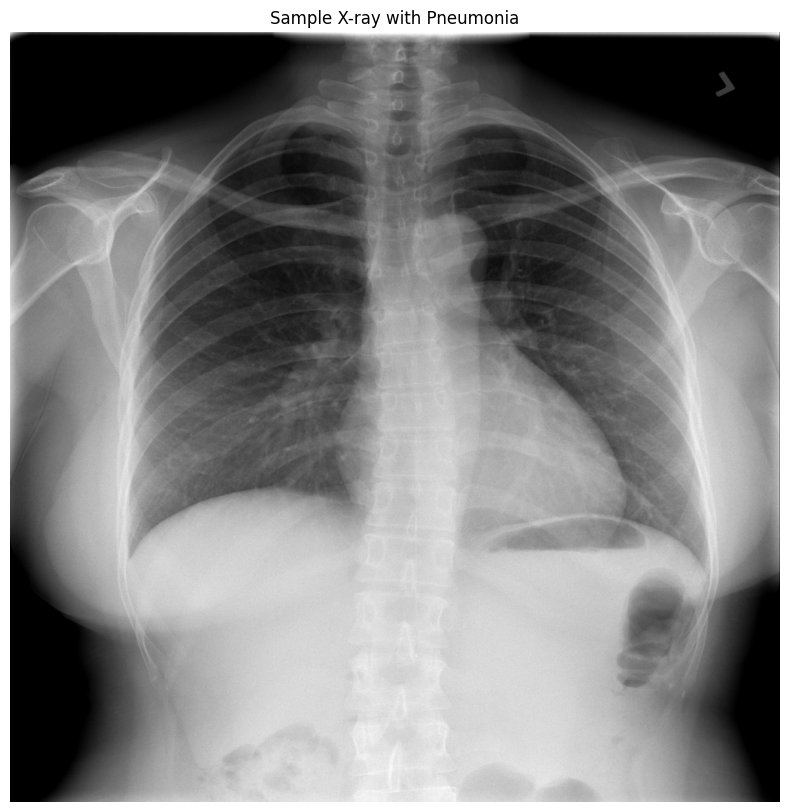

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.



=== CHEST X-RAY FINDINGS ===

Positive Findings:
- None detected with high confidence

Uncertain Findings:
- Pleural_Thickening (Confidence: 0.68)
- Infiltration (Confidence: 0.39)
- Fibrosis (Confidence: 0.39)

Impression:
Possible findings (low confidence): Pleural_Thickening, Infiltration, Fibrosis

=== INTERACTIVE Q&A ===

Question: What are the key features of Pneumonia visible in this X-ray?
Answer: ..........................................

Question: What is the differential diagnosis for this case?
Answer: ...............................................

Question: What follow-up tests would you recommend for this patient?
Answer: ............................................

Full report generated and saved to 'chest_xray_report.html'

Streamlit app code generated. You can run this code with 'streamlit run app.py'


In [12]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import base64
from io import BytesIO
import json
from datetime import datetime

# 1. SETUP LLM COMPONENT
def setup_llm_components():
    """
    Initialize the language model components for medical Q&A
    """
    print("Setting up LLM components...")
    
    # Load tokenizer and model
    # Using a smaller medical LM that can fit in Kaggle's memory constraints
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
    
    # Create a text generation pipeline
    nlp = pipeline(
        "text-generation",
        model="microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
        tokenizer=tokenizer,
        max_length=150
    )
    
    return tokenizer, nlp

# 2. GENERATE STRUCTURED FINDINGS
def generate_structured_findings(model, img_path, transform, disease_labels, optimal_thresholds=None):
    """
    Generate structured findings from an X-ray image using the vision model
    """
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    
    # Preprocess the image
    image = Image.open(img_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Get predictions
    with torch.no_grad():
        outputs = model(input_tensor)
        outputs = torch.sigmoid(outputs)
    
    # Convert to numpy
    predictions = outputs[0].cpu().numpy()
    
    # Apply optimal thresholds if available
    if optimal_thresholds:
        binary_preds = np.zeros_like(predictions)
        for i, disease in enumerate(disease_labels):
            if disease in optimal_thresholds:
                binary_preds[i] = predictions[i] > optimal_thresholds[disease]
            else:
                binary_preds[i] = predictions[i] > 0.5
    else:
        binary_preds = predictions > 0.5
    
    # Create structured findings
    structured_findings = {
        "image_path": img_path,
        "predictions": {},
        "positive_findings": [],
        "negative_findings": [],
        "uncertain_findings": [],
        "impression": ""
    }
    
    # Fill predictions and findings
    for i, disease in enumerate(disease_labels):
        score = float(predictions[i])
        structured_findings["predictions"][disease] = score
        
        # Categorize findings based on confidence and thresholds
        if binary_preds[i]:  # Above threshold
            if score > 0.7:  # High confidence
                structured_findings["positive_findings"].append((disease, score))
            else:  # Medium confidence
                structured_findings["uncertain_findings"].append((disease, score))
        elif score < 0.2:  # Low probability, high confidence of absence
            structured_findings["negative_findings"].append((disease, score))
    
    # Sort findings by confidence
    structured_findings["positive_findings"].sort(key=lambda x: x[1], reverse=True)
    structured_findings["uncertain_findings"].sort(key=lambda x: x[1], reverse=True)
    structured_findings["negative_findings"].sort(key=lambda x: x[1])
    
    # Generate impression
    if structured_findings["positive_findings"]:
        impression = "Findings suggestive of: " + ", ".join([d for d, _ in structured_findings["positive_findings"][:3]])
        if structured_findings["uncertain_findings"]:
            impression += ". Possible findings (lower confidence): " + ", ".join([d for d, _ in structured_findings["uncertain_findings"][:2]])
    elif structured_findings["uncertain_findings"]:
        impression = "Possible findings (low confidence): " + ", ".join([d for d, _ in structured_findings["uncertain_findings"][:3]])
    else:
        impression = "No significant abnormalities detected with high confidence."
    
    structured_findings["impression"] = impression
    
    return structured_findings

# 3. GENERATE LLM PROMPT
def generate_llm_prompt(findings, question):
    """
    Create a prompt for the LLM using the structured findings and user question
    """
    # Format positive findings
    positive_findings = ""
    if findings["positive_findings"]:
        for disease, score in findings["positive_findings"]:
            positive_findings += f"- {disease} (confidence: {score:.2f})\n"
    else:
        positive_findings = "- None detected with high confidence\n"
    
    # Format uncertain findings
    uncertain_findings = ""
    if findings["uncertain_findings"]:
        for disease, score in findings["uncertain_findings"]:
            uncertain_findings += f"- {disease} (confidence: {score:.2f})\n"
    else:
        uncertain_findings = "- None\n"
    
    # Format prompt
    prompt = f"""
CHEST X-RAY ANALYSIS
====================
FINDINGS WITH HIGH CONFIDENCE:
{positive_findings}

FINDINGS WITH UNCERTAIN CONFIDENCE:
{uncertain_findings}

RADIOLOGIST IMPRESSION:
{findings["impression"]}

CLINICAL QUESTION:
{question}

ANSWER:
"""
    
    return prompt

# 4. ANSWER CLINICAL QUESTIONS
def answer_clinical_question(nlp, findings, question):
    """
    Generate an answer to a clinical question using the LLM
    """
    # Generate prompt
    prompt = generate_llm_prompt(findings, question)
    
    # Get response from LLM
    result = nlp(prompt, max_length=150, num_return_sequences=1)
    response = result[0]['generated_text']
    
    # Extract just the answer part
    answer = response.split("ANSWER:")[1].strip()
    
    return answer

# 5. CREATE UNIFIED REPORT
def generate_unified_report(image_path, findings, qa_pairs, disease_labels):
    """
    Generate a complete HTML report combining image, findings, and Q&A
    """
    # Load and encode image
    image = Image.open(image_path).convert('RGB')
    buffered = BytesIO()
    image.save(buffered, format="JPEG")
    img_str = base64.b64encode(buffered.getvalue()).decode()
    
    # Format findings for HTML
    positive_findings_html = ""
    if findings["positive_findings"]:
        for disease, score in findings["positive_findings"]:
            confidence_class = "high" if score > 0.8 else "medium"
            positive_findings_html += f'<li class="confidence-{confidence_class}">{disease} (Confidence: {score:.2f})</li>'
    else:
        positive_findings_html = "<li>No positive findings with high confidence</li>"
    
    uncertain_findings_html = ""
    if findings["uncertain_findings"]:
        for disease, score in findings["uncertain_findings"]:
            uncertain_findings_html += f'<li class="confidence-low">{disease} (Confidence: {score:.2f})</li>'
    
    # Format Q&A section
    qa_html = ""
    for question, answer in qa_pairs:
        qa_html += f"""
        <div class="qa-item">
            <div class="question"><strong>Q:</strong> {question}</div>
            <div class="answer"><strong>A:</strong> {answer}</div>
        </div>
        """
    
    # Create the HTML report
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Chest X-ray Analysis Report</title>
        <style>
            body {{ font-family: Arial, sans-serif; margin: 20px; color: #333; }}
            .header {{ background-color: #2c3e50; color: white; padding: 15px; border-radius: 5px; }}
            .container {{ display: flex; flex-wrap: wrap; margin-top: 20px; }}
            .image-section {{ flex: 1; min-width: 300px; margin-right: 20px; }}
            .findings-section {{ flex: 2; min-width: 300px; }}
            img {{ max-width: 100%; border: 1px solid #ddd; border-radius: 5px; }}
            h2 {{ color: #2c3e50; border-bottom: 1px solid #eee; padding-bottom: 5px; }}
            ul {{ list-style-type: none; padding-left: 0; }}
            li {{ margin-bottom: 8px; padding: 5px; border-radius: 3px; }}
            .confidence-high {{ background-color: rgba(46, 204, 113, 0.2); }}
            .confidence-medium {{ background-color: rgba(241, 196, 15, 0.2); }}
            .confidence-low {{ background-color: rgba(231, 76, 60, 0.2); }}
            .impression {{ font-weight: bold; margin: 15px 0; padding: 10px; background-color: #f8f9fa; border-radius: 5px; }}
            .qa-section {{ margin-top: 30px; }}
            .qa-item {{ margin-bottom: 15px; background-color: #f8f9fa; padding: 10px; border-radius: 5px; }}
            .question {{ margin-bottom: 10px; }}
            .answer {{ padding-left: 15px; }}
        </style>
    </head>
    <body>
        <div class="header">
            <h1>Chest X-ray Analysis Report</h1>
            <p>Generated on {datetime.now().strftime('%B %d, %Y at %H:%M')}</p>
        </div>
        
        <div class="container">
            <div class="image-section">
                <h2>X-ray Image</h2>
                <img src="data:image/jpeg;base64,{img_str}" alt="Chest X-ray">
            </div>
            
            <div class="findings-section">
                <h2>Findings</h2>
                <h3>Positive Findings</h3>
                <ul>
                    {positive_findings_html}
                </ul>
                
                <h3>Uncertain Findings</h3>
                <ul>
                    {uncertain_findings_html}
                </ul>
                
                <div class="impression">
                    <h3>Impression</h3>
                    <p>{findings["impression"]}</p>
                </div>
            </div>
        </div>
        
        <div class="qa-section">
            <h2>Clinical Questions & Answers</h2>
            {qa_html}
        </div>
        
        <div style="margin-top: 30px; font-size: 0.8em; color: #777;">
            <p>This report was generated by an AI system and should be reviewed by a healthcare professional. 
            The model has been trained on the NIH Chest X-ray dataset.</p>
        </div>
    </body>
    </html>
    """
    
    return html

# 6. CREATE STREAMLIT INTERFACE
def create_streamlit_app_code():
    """
    Generate the code for a Streamlit interface
    """
    code = """
import streamlit as st
import torch
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from transformers import pipeline

# Load the models
@st.cache_resource
def load_models():
    # Load vision model
    vision_model = ImprovedChestXrayModel(len(disease_labels))
    vision_model.load_state_dict(torch.load('best_improved_model.pth', weights_only=True))
    vision_model.eval()
    
    # Load LLM
    tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext")
    nlp = pipeline(
        "text-generation",
        model="microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
        tokenizer=tokenizer
    )
    
    return vision_model, nlp

# Main function
def main():
    st.title("Chest X-ray Analysis with Multimodal AI")
    st.write("Upload a chest X-ray image and get AI analysis with Q&A capability")
    
    # Load models
    vision_model, nlp = load_models()
    
    # File uploader
    uploaded_file = st.file_uploader("Upload a chest X-ray image", type=["png", "jpg", "jpeg"])
    
    if uploaded_file is not None:
        # Display the image
        image = Image.open(uploaded_file)
        st.image(image, caption="Uploaded X-ray", use_column_width=True)
        
        # Save the image temporarily
        temp_path = "temp_image.png"
        image.save(temp_path)
        
        # Generate findings
        with st.spinner("Analyzing the X-ray..."):
            findings = generate_structured_findings(
                vision_model, 
                temp_path, 
                data_transforms['val'],
                disease_labels,
                optimal_thresholds
            )
        
        # Display findings
        st.subheader("AI Findings")
        
        # Positive findings
        st.write("**Positive Findings:**")
        if findings["positive_findings"]:
            for disease, score in findings["positive_findings"]:
                st.write(f"- {disease} (Confidence: {score:.2f})")
        else:
            st.write("- No positive findings with high confidence")
        
        # Uncertain findings
        if findings["uncertain_findings"]:
            st.write("**Uncertain Findings:**")
            for disease, score in findings["uncertain_findings"]:
                st.write(f"- {disease} (Confidence: {score:.2f})")
        
        # Impression
        st.write("**Impression:**")
        st.write(findings["impression"])
        
        # Q&A Section
        st.subheader("Ask about this X-ray")
        question = st.text_input("Enter your clinical question:")
        
        qa_pairs = []
        if st.button("Get Answer") and question:
            with st.spinner("Generating answer..."):
                answer = answer_clinical_question(nlp, findings, question)
            
            st.write("**Question:**")
            st.write(question)
            st.write("**Answer:**")
            st.write(answer)
            
            qa_pairs.append((question, answer))
        
        # Generate report button
        if st.button("Generate Full Report"):
            with st.spinner("Generating comprehensive report..."):
                report_html = generate_unified_report(
                    temp_path,
                    findings,
                    qa_pairs,
                    disease_labels
                )
                
                # Save the report
                with open("chest_xray_report.html", "w") as f:
                    f.write(report_html)
            
            # Provide download link
            with open("chest_xray_report.html", "rb") as f:
                st.download_button(
                    label="Download Report",
                    data=f,
                    file_name="chest_xray_report.html",
                    mime="text/html"
                )

if __name__ == "__main__":
    main()
    """
    
    return code

# 7. DEMO FUNCTION FOR INTERACTIVE TESTING
def run_multimodal_demo(model, disease_labels, optimal_thresholds, data_transforms, data_path, test_df):
    """
    Run a demonstration of the multimodal system using the test set
    """
    # Set up LLM components
    tokenizer, nlp = setup_llm_components()
    
    # Select a sample from the test set
    disease_to_show = "Pneumonia"  # Can be changed to any of the 14 diseases
    
    # Find a sample with the specified disease
    sample_df = test_df[test_df[disease_to_show] == 1]
    
    if len(sample_df) == 0:
        print(f"No examples of {disease_to_show} found in test set.")
        return
    
    # Take the first example
    sample = sample_df.iloc[0]
    img_name = sample['Image Index']
    
    # Find the image path
    img_path = None
    for folder in os.listdir(data_path):
        if folder.startswith('images_'):
            # Check if there's a nested 'images' folder
            nested_path = os.path.join(data_path, folder, 'images', img_name)
            direct_path = os.path.join(data_path, folder, img_name)
            
            if os.path.exists(nested_path):
                img_path = nested_path
                break
            elif os.path.exists(direct_path):
                img_path = direct_path
                break
    
    if img_path is None:
        print(f"Could not find image {img_name} in any folder.")
        return
    
    print(f"Running demo on image: {img_path}")
    
    # Generate findings
    findings = generate_structured_findings(
        model, 
        img_path, 
        data_transforms['val'], 
        disease_labels,
        optimal_thresholds
    )
    
    # Display the image
    image = Image.open(img_path).convert('RGB')
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Sample X-ray with {disease_to_show}")
    plt.show()
    
    # Print findings
    print("\n=== CHEST X-RAY FINDINGS ===")
    print("\nPositive Findings:")
    if findings["positive_findings"]:
        for disease, score in findings["positive_findings"]:
            print(f"- {disease} (Confidence: {score:.2f})")
    else:
        print("- None detected with high confidence")
    
    print("\nUncertain Findings:")
    if findings["uncertain_findings"]:
        for disease, score in findings["uncertain_findings"]:
            print(f"- {disease} (Confidence: {score:.2f})")
    else:
        print("- None")
    
    print("\nImpression:")
    print(findings["impression"])
    
    # Interactive Q&A
    print("\n=== INTERACTIVE Q&A ===")
    questions = [
        f"What are the key features of {disease_to_show} visible in this X-ray?",
        f"What is the differential diagnosis for this case?",
        "What follow-up tests would you recommend for this patient?"
    ]
    
    qa_pairs = []
    for question in questions:
        print(f"\nQuestion: {question}")
        answer = answer_clinical_question(nlp, findings, question)
        print(f"Answer: {answer}")
        qa_pairs.append((question, answer))
    
    # Generate and save the full report
    report_html = generate_unified_report(img_path, findings, qa_pairs, disease_labels)
    
    with open("chest_xray_report.html", "w") as f:
        f.write(report_html)
    
    print("\nFull report generated and saved to 'chest_xray_report.html'")
    
    return findings, qa_pairs

# 8. FINAL EVALUATION
def evaluate_multimodal_system(model, disease_labels, optimal_thresholds, data_transforms, test_loader, test_df):
    """
    Evaluate the complete multimodal system on the test set
    """
    print("Evaluating multimodal system...")
    
    # 1. Vision model performance (already calculated)
    # Just print a summary
    print("\n=== VISION MODEL PERFORMANCE ===")
    print(f"Mean AUC: {evaluation_results['mean_metrics']['auc']:.4f}")
    print(f"Mean F1 Score: {evaluation_results['mean_metrics']['f1']:.4f}")
    
    # 2. LLM integration (qualitative assessment)
    # Run a sample analysis
    print("\n=== LLM INTEGRATION SAMPLE ===")
    
    # Set up LLM components
    tokenizer, nlp = setup_llm_components()
    
    # Choose a few diseases to evaluate
    test_diseases = ["Pneumonia", "Cardiomegaly", "Effusion", "Nodule", "Mass"]
    
    qualitative_results = {}
    
    for disease in test_diseases:
        # Find a sample
        sample_df = test_df[test_df[disease] == 1].head(1)
        
        if len(sample_df) == 0:
            print(f"No examples of {disease} found in test set.")
            continue
        
        sample = sample_df.iloc[0]
        img_name = sample['Image Index']
        
        # Find the image path
        img_path = None
        for folder in os.listdir(data_path):
            if folder.startswith('images_'):
                nested_path = os.path.join(data_path, folder, 'images', img_name)
                direct_path = os.path.join(data_path, folder, img_name)
                
                if os.path.exists(nested_path):
                    img_path = nested_path
                    break
                elif os.path.exists(direct_path):
                    img_path = direct_path
                    break
        
        if img_path is None:
            continue
        
        # Generate findings
        findings = generate_structured_findings(
            model, 
            img_path, 
            data_transforms['val'], 
            disease_labels,
            optimal_thresholds
        )
        
        # Ask a question about the disease
        question = f"What are the key features of {disease} visible in this X-ray?"
        answer = answer_clinical_question(nlp, findings, question)
        
        # Store results
        qualitative_results[disease] = {
            "img_path": img_path,
            "ground_truth": disease,
            "model_confidence": findings["predictions"].get(disease, 0),
            "in_positive_findings": any(d == disease for d, _ in findings["positive_findings"]),
            "question": question,
            "answer": answer
        }
        
        # Print a summary
        print(f"\nDisease: {disease}")
        print(f"Model confidence: {findings['predictions'].get(disease, 0):.4f}")
        print(f"In positive findings: {any(d == disease for d, _ in findings['positive_findings'])}")
        print(f"Question: {question}")
        print(f"Answer: {answer}")
    
    # 3. Fusion evaluation (simple metrics)
    correct_positive = sum(1 for d in qualitative_results if qualitative_results[d]["in_positive_findings"])
    accuracy = correct_positive / len(qualitative_results) if qualitative_results else 0
    
    print("\n=== FUSION PERFORMANCE ===")
    print(f"Accuracy of including ground truth in positive findings: {accuracy:.4f}")
    
    return qualitative_results

# Run the multimodal demo
findings, qa_pairs = run_multimodal_demo(
    improved_model, 
    disease_labels, 
    evaluation_results['optimal_thresholds'], 
    data_transforms, 
    data_path, 
    test_df
)

# Generate code for Streamlit app
streamlit_code = create_streamlit_app_code()
print("\nStreamlit app code generated. You can run this code with 'streamlit run app.py'")

In [13]:
# Save the model architecture and weights
MODEL_PATH = "chest_xray_model.pth"
torch.save({
    'model_state_dict': improved_model.state_dict(),
    'model_class': 'ImprovedChestXrayModel',
    'num_classes': len(disease_labels),
    'disease_labels': disease_labels,
    'optimal_thresholds': evaluation_results['optimal_thresholds'],
}, MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")

Model saved to chest_xray_model.pth


In [14]:
# Save metadata as JSON
import json

metadata = {
    'disease_labels': disease_labels,
    'optimal_thresholds': {k: float(v) for k, v in evaluation_results['optimal_thresholds'].items()},
    'mean_auc': float(evaluation_results['mean_metrics']['auc']),
    'mean_f1': float(evaluation_results['mean_metrics']['f1']),
    'model_performance': {
        'auc_scores': {k: float(v) for k, v in evaluation_results['auc_scores'].items()},
        'precision': {k: float(v) for k, v in evaluation_results['precision'].items()},
        'recall': {k: float(v) for k, v in evaluation_results['recall'].items()},
        'f1': {k: float(v) for k, v in evaluation_results['f1'].items()},
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("Metadata saved to model_metadata.json")

Metadata saved to model_metadata.json


In [15]:
!pip install streamlit

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 90.5 MB/s eta 0:00:00


In [16]:
# Save the model architecture and weights
MODEL_PATH = "chest_xray_model.pth"
torch.save({
    'model_state_dict': improved_model.state_dict(),
    'model_class': 'ImprovedChestXrayModel',
    'num_classes': len(disease_labels),
    'disease_labels': disease_labels,
    'optimal_thresholds': evaluation_results['optimal_thresholds'],
}, MODEL_PATH)

print(f"Model saved to {MODEL_PATH}")

# Save metadata as JSON
import json

metadata = {
    'disease_labels': disease_labels,
    'optimal_thresholds': {k: float(v) for k, v in evaluation_results['optimal_thresholds'].items()},
    'mean_auc': float(evaluation_results['mean_metrics']['auc']),
    'mean_f1': float(evaluation_results['mean_metrics']['f1']),
    'model_performance': {
        'auc_scores': {k: float(v) for k, v in evaluation_results['auc_scores'].items()},
        'precision': {k: float(v) for k, v in evaluation_results['precision'].items()},
        'recall': {k: float(v) for k, v in evaluation_results['recall'].items()},
        'f1': {k: float(v) for k, v in evaluation_results['f1'].items()},
    }
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=4)

print("Metadata saved to model_metadata.json")



Model saved to chest_xray_model.pth
Metadata saved to model_metadata.json
